
# Prediction Intervals for Gradient Boosting Regression

This example shows how quantile regression can be used to create prediction
intervals.


Generate some data for a synthetic regression problem by applying the
function f to uniformly sampled random inputs.



In [2]:
import numpy as np

from sklearn.model_selection import train_test_split


def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

To make the problem interesting, we generate observations of the target y as
the sum of a deterministic term computed by the function f and a random noise
term that follows a centered [log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution). To make this even
more interesting we consider the case where the amplitude of the noise
depends on the input variable x (heteroscedastic noise).

The lognormal distribution is non-symmetric and long tailed: observing large
outliers is likely but it is impossible to observe small outliers.



In [3]:
sigma = 0.5 + X.ravel() / 10
noise = rng.lognormal(sigma=sigma) - np.exp(sigma**2 / 2)
y = expected_y + noise

Split into train, test datasets:



In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Fitting non-linear quantile and least squares regressors

Fit gradient boosting models trained with the quantile loss and
alpha=0.05, 0.5, 0.95.

The models obtained for alpha=0.05 and alpha=0.95 produce a 90% confidence
interval (95% - 5% = 90%).

The model trained with alpha=0.5 produces a regression of the median: on
average, there should be the same number of target observations above and
below the predicted values.



In [5]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

Notice that :class:`~sklearn.ensemble.HistGradientBoostingRegressor` is much
faster than :class:`~sklearn.ensemble.GradientBoostingRegressor` starting with
intermediate datasets (`n_samples >= 10_000`), which is not the case of the
present example.

For the sake of comparison, we also fit a baseline model trained with the
usual (mean) squared error (MSE).



In [6]:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

Create an evenly spaced evaluation set of input values spanning the [0, 10]
range.



In [7]:
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T

Plot the true conditional mean function f, the predictions of the conditional
mean (loss equals squared error), the conditional median and the conditional
90% interval (from 5th to 95th conditional percentiles).



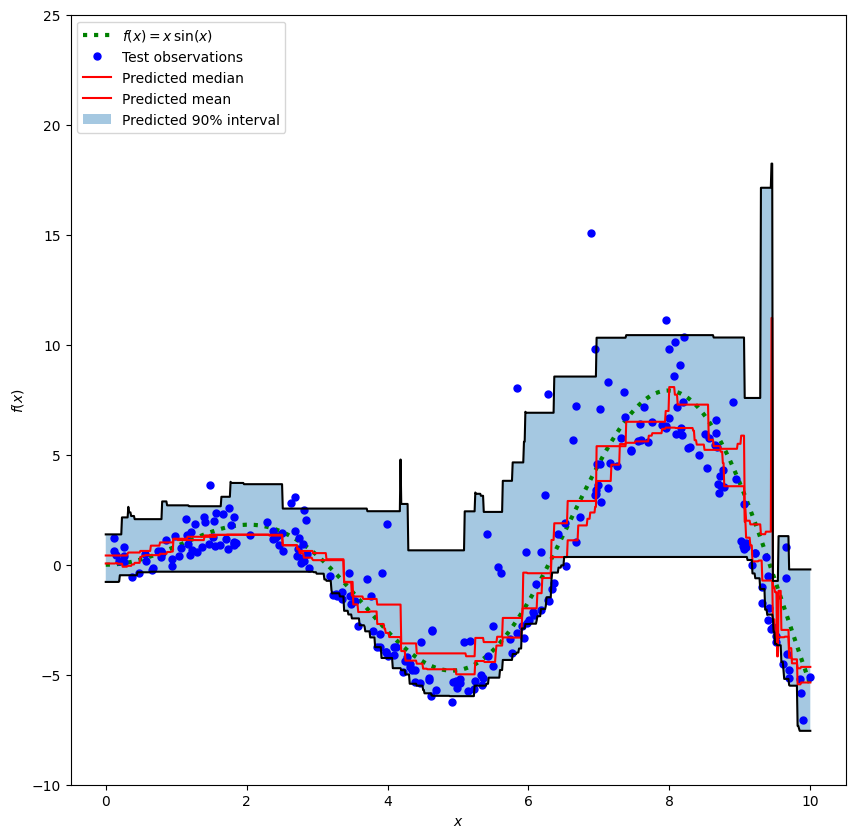

In [8]:
import matplotlib.pyplot as plt

y_pred = all_models["mse"].predict(xx)
y_lower = all_models["q 0.05"].predict(xx)
y_upper = all_models["q 0.95"].predict(xx)
y_med = all_models["q 0.50"].predict(xx)

fig = plt.figure(figsize=(10, 10))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_med, "r-", label="Predicted median")
plt.plot(xx, y_pred, "r-", label="Predicted mean")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc="upper left")
plt.show()

Comparing the predicted median with the predicted mean, we note that the
median is on average below the mean as the noise is skewed towards high
values (large outliers). The median estimate also seems to be smoother
because of its natural robustness to outliers.

Also observe that the inductive bias of gradient boosting trees is
unfortunately preventing our 0.05 quantile to fully capture the sinoisoidal
shape of the signal, in particular around x=8. Tuning hyper-parameters can
reduce this effect as shown in the last part of this notebook.

## Analysis of the error metrics

Measure the models with :func:`~sklearn.metrics.mean_squared_error` and
:func:`~sklearn.metrics.mean_pinball_loss` metrics on the training dataset.



In [9]:
import pandas as pd


def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


results = []
for name, gbr in sorted(all_models.items()):
    metrics = {"model": name}
    y_pred = gbr.predict(X_train)
    for alpha in [0.05, 0.5, 0.95]:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_train, y_pred, alpha=alpha)
    metrics["MSE"] = mean_squared_error(y_train, y_pred)
    results.append(metrics)

pd.DataFrame(results).set_index("model").style.apply(highlight_min)

,pbl=0.05,pbl=0.50,pbl=0.95,MSE
model,,,,
mse,0.715413,0.715413,0.715413,7.750348
q 0.05,0.127128,1.253445,2.379763,18.933253
q 0.50,0.305438,0.622811,0.940184,9.827917
q 0.95,3.909909,2.145957,0.382005,28.667219


One column shows all models evaluated by the same metric. The minimum number
on a column should be obtained when the model is trained and measured with
the same metric. This should be always the case on the training set if the
training converged.

Note that because the target distribution is asymmetric, the expected
conditional mean and conditional median are significantly different and
therefore one could not use the squared error model get a good estimation of
the conditional median nor the converse.

If the target distribution were symmetric and had no outliers (e.g. with a
Gaussian noise), then median estimator and the least squares estimator would
have yielded similar predictions.

We then do the same on the test set.



In [10]:
results = []
for name, gbr in sorted(all_models.items()):
    metrics = {"model": name}
    y_pred = gbr.predict(X_test)
    for alpha in [0.05, 0.5, 0.95]:
        metrics["pbl=%1.2f" % alpha] = mean_pinball_loss(y_test, y_pred, alpha=alpha)
    metrics["MSE"] = mean_squared_error(y_test, y_pred)
    results.append(metrics)

pd.DataFrame(results).set_index("model").style.apply(highlight_min)

,pbl=0.05,pbl=0.50,pbl=0.95,MSE
model,,,,
mse,0.917281,0.767498,0.617715,6.692901
q 0.05,0.144204,1.245961,2.347717,15.648026
q 0.50,0.412021,0.607752,0.803483,5.874771
q 0.95,4.354394,2.355445,0.356497,34.852774


Errors are higher meaning the models slightly overfitted the data. It still
shows that the best test metric is obtained when the model is trained by
minimizing this same metric.

Note that the conditional median estimator is competitive with the squared
error estimator in terms of MSE on the test set: this can be explained by
the fact the squared error estimator is very sensitive to large outliers
which can cause significant overfitting. This can be seen on the right hand
side of the previous plot. The conditional median estimator is biased
(underestimation for this asymmetric noise) but is also naturally robust to
outliers and overfits less.

## Calibration of the confidence interval

We can also evaluate the ability of the two extreme quantile estimators at
producing a well-calibrated conditional 90%-confidence interval.

To do this we can compute the fraction of observations that fall between the
predictions:



In [11]:
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))


coverage_fraction(
    y_train,
    all_models["q 0.05"].predict(X_train),
    all_models["q 0.95"].predict(X_train),
)

0.9

On the training set the calibration is very close to the expected coverage
value for a 90% confidence interval.



In [12]:
coverage_fraction(
    y_test, all_models["q 0.05"].predict(X_test), all_models["q 0.95"].predict(X_test)
)

0.868

On the test set, the estimated confidence interval is slightly too narrow.
Note, however, that we would need to wrap those metrics in a cross-validation
loop to assess their variability under data resampling.

## Tuning the hyper-parameters of the quantile regressors

In the plot above, we observed that the 5th percentile regressor seems to
underfit and could not adapt to sinusoidal shape of the signal.

The hyper-parameters of the model were approximately hand-tuned for the
median regressor and there is no reason that the same hyper-parameters are
suitable for the 5th percentile regressor.

To confirm this hypothesis, we tune the hyper-parameters of a new regressor
of the 5th percentile by selecting the best model parameters by
cross-validation on the pinball loss with alpha=0.05:



In [13]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint

param_grid = dict(
    learning_rate=[0.05, 0.1, 0.2],
    max_depth=[2, 5, 10],
    min_samples_leaf=[1, 5, 10, 20],
    min_samples_split=[5, 10, 20, 30, 50],
)
alpha = 0.05
neg_mean_pinball_loss_05p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=alpha,
    greater_is_better=False,  # maximize the negative loss
)
gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, random_state=0)
search_05p = HalvingRandomSearchCV(
    gbr,
    param_grid,
    resource="n_estimators",
    max_resources=250,
    min_resources=50,
    scoring=neg_mean_pinball_loss_05p_scorer,
    n_jobs=2,
    random_state=0,
).fit(X_train, y_train)
pprint(search_05p.best_params_)

{'learning_rate': 0.2,
 'max_depth': 2,
 'min_samples_leaf': 20,
 'min_samples_split': 10,
 'n_estimators': 150}


We observe that the hyper-parameters that were hand-tuned for the median
regressor are in the same range as the hyper-parameters suitable for the 5th
percentile regressor.

Let's now tune the hyper-parameters for the 95th percentile regressor. We
need to redefine the `scoring` metric used to select the best model, along
with adjusting the alpha parameter of the inner gradient boosting estimator
itself:



In [14]:
from sklearn.base import clone

alpha = 0.95
neg_mean_pinball_loss_95p_scorer = make_scorer(
    mean_pinball_loss,
    alpha=alpha,
    greater_is_better=False,  # maximize the negative loss
)
search_95p = clone(search_05p).set_params(
    estimator__alpha=alpha,
    scoring=neg_mean_pinball_loss_95p_scorer,
)
search_95p.fit(X_train, y_train)
pprint(search_95p.best_params_)

{'learning_rate': 0.05,
 'max_depth': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 20,
 'n_estimators': 150}


The result shows that the hyper-parameters for the 95th percentile regressor
identified by the search procedure are roughly in the same range as the hand-
tuned hyper-parameters for the median regressor and the hyper-parameters
identified by the search procedure for the 5th percentile regressor. However,
the hyper-parameter searches did lead to an improved 90% confidence interval
that is comprised by the predictions of those two tuned quantile regressors.
Note that the prediction of the upper 95th percentile has a much coarser shape
than the prediction of the lower 5th percentile because of the outliers:



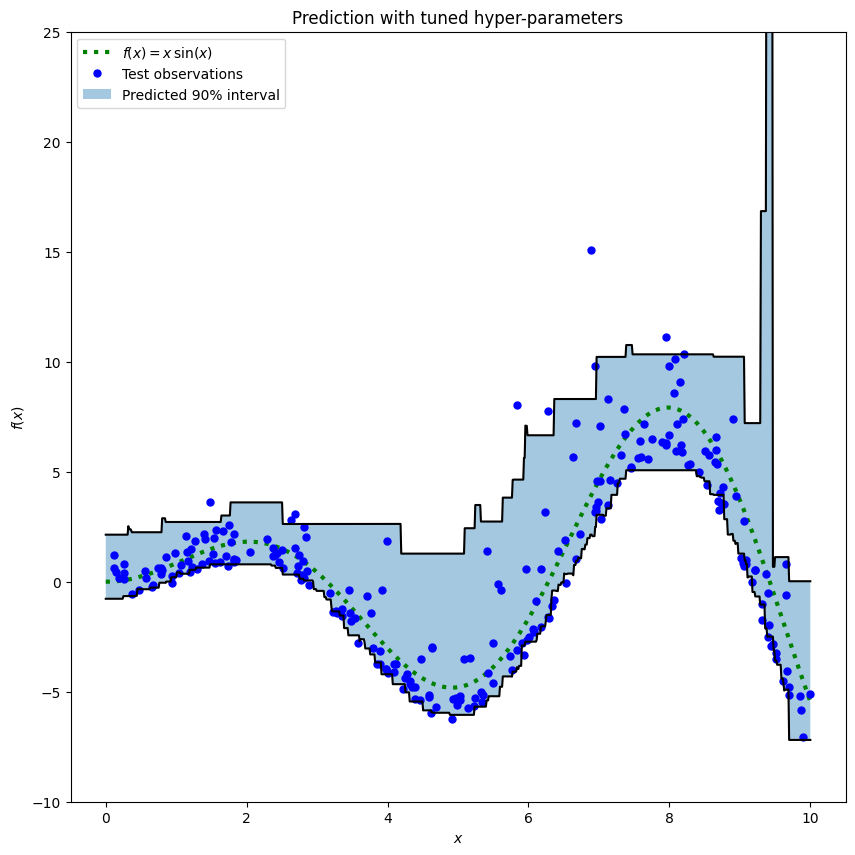

In [15]:
y_lower = search_05p.predict(xx)
y_upper = search_95p.predict(xx)

fig = plt.figure(figsize=(10, 10))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc="upper left")
plt.title("Prediction with tuned hyper-parameters")
plt.show()

The plot looks qualitatively better than for the untuned models, especially
for the shape of the of lower quantile.

We now quantitatively evaluate the joint-calibration of the pair of
estimators:



In [16]:
coverage_fraction(y_train, search_05p.predict(X_train), search_95p.predict(X_train))

0.9026666666666666

In [17]:
coverage_fraction(y_test, search_05p.predict(X_test), search_95p.predict(X_test))

0.796

The calibration of the tuned pair is sadly not better on the test set: the
width of the estimated confidence interval is still too narrow.

Again, we would need to wrap this study in a cross-validation loop to
better assess the variability of those estimates.

